In [264]:
import os
import cx_Oracle
import pandas as pd
import numpy as np
import pickle
from datetime import date,datetime
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, cross_val_score 
import time
import matplotlib.pyplot as plt
from sklearn.utils import resample
import datetime

# Data Read And Clean

In [265]:
df = pd.read_pickle(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Common Maps KNN\Data Files\data_dump_income_pred.pkl")

In [266]:
df = df[["SKP_CREDIT_CASE","TIME_DECISION_DATE","CUS_LAT","CUS_LONG","RISK_FSTQPD30",
"RISK_SCORE","GRID_ID","CLIENT_INR_INCOME"]]

In [267]:
df.dropna(subset = ["RISK_SCORE"], inplace = True)

In [268]:
df["MONTH_STR"] = df["TIME_DECISION_DATE"].dt.strftime("%Y-%m")

### Remove outliers from income...top 1 percentiles

In [269]:
df = df[df["CLIENT_INR_INCOME"]<df["CLIENT_INR_INCOME"].quantile(0.99)]

# KNN Implementation

### Split in train test validation set 

In [270]:
# Split Train and Test Data Set
df_train = df[(df["TIME_DECISION_DATE"]>=datetime.datetime(2018, 7, 1)) & 
              (df["TIME_DECISION_DATE"]<=datetime.datetime(2018, 12, 1))]
df_valid = df[(df["TIME_DECISION_DATE"]>=datetime.datetime(2019, 1, 1)) & 
              (df["TIME_DECISION_DATE"]<=datetime.datetime(2019, 1, 31))]
df_test = df[(df["TIME_DECISION_DATE"]>=datetime.datetime(2019, 2, 1)) & 
              (df["TIME_DECISION_DATE"]<=datetime.datetime(2019, 3, 31))]

In [271]:
print(df_train.shape)
print(df_valid.shape)
print(df_test.shape)


(1398762, 9)
(297066, 9)
(538078, 9)


### Downsample training data

In [272]:
seed = 26
df_train= df_train.sample(n=800000, random_state=seed)

In [273]:
X_train = df_train[["CUS_LAT","CUS_LONG","TIME_DECISION_DATE"]]
X_test = df_test[["CUS_LAT","CUS_LONG","TIME_DECISION_DATE"]]
X_valid = df_valid[["CUS_LAT","CUS_LONG","TIME_DECISION_DATE"]]

y_train = df_train["CLIENT_INR_INCOME"]
y_test =  df_test["CLIENT_INR_INCOME"]
y_valid =  df_valid["CLIENT_INR_INCOME"]


### Calculate optimum K for KNN

In [274]:
from sklearn.neighbors import KNeighborsRegressor
rmse_val = [] #to store rmse values for different k
for K in np.arange(1,1000,100):
    model = KNeighborsRegressor(n_neighbors = K)
    model.fit(X_train[["CUS_LAT","CUS_LONG"]], np.ravel(y_train))  #fit the model
    pred=model.predict(X_valid[["CUS_LAT","CUS_LONG"]]) #make prediction on valid set
    error = np.sqrt(metrics.mean_squared_error(y_valid,pred)) #calculate rmse
    rmse_val.append(error) #store rmse values
    print('RMSE value for k= ' , K , 'is:', error)
    

RMSE value for k=  1 is: 7749.076646415858
RMSE value for k=  101 is: 5465.435326774326
RMSE value for k=  201 is: 5457.099708596304
RMSE value for k=  301 is: 5456.051452098188
RMSE value for k=  401 is: 5456.231153225755
RMSE value for k=  501 is: 5457.216218167015
RMSE value for k=  601 is: 5457.876707857313
RMSE value for k=  701 is: 5459.289002290872
RMSE value for k=  801 is: 5460.624291644202
RMSE value for k=  901 is: 5461.947721899473


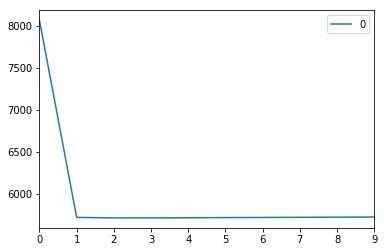

In [230]:
curve = pd.DataFrame(rmse_val) #elbow curve 
curve.plot()

In [231]:
rmse_val = [] #to store rmse values for different k
for K in np.arange(100,200,20):
    model = KNeighborsRegressor(n_neighbors = K)
    model.fit(X_train[["CUS_LAT","CUS_LONG"]], np.ravel(y_train))  #fit the model
    pred=model.predict(X_valid[["CUS_LAT","CUS_LONG"]]) #make prediction on valid set
    error = np.sqrt(metrics.mean_squared_error(y_valid,pred)) #calculate rmse
    rmse_val.append(error) #store rmse values
    print('RMSE value for k= ' , K , 'is:', error)

RMSE value for k=  100 is: 5722.997915624049
RMSE value for k=  120 is: 5720.948990813818
RMSE value for k=  140 is: 5719.054255144561
RMSE value for k=  160 is: 5718.641952329045
RMSE value for k=  180 is: 5717.096834696298


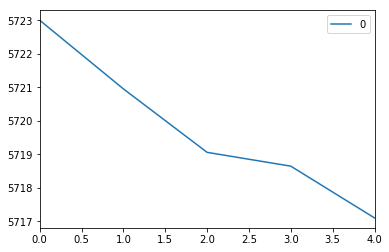

In [232]:
curve = pd.DataFrame(rmse_val) #elbow curve 
curve.plot()

### Train model with optimum K

In [262]:
from sklearn.neighbors import KNeighborsRegressor
# Create KNN classifier
model = KNeighborsRegressor(n_neighbors=201)
bst = model.fit(X_train[["CUS_LAT","CUS_LONG"]], np.ravel(y_train))
pred_train=model.predict(X_train[["CUS_LAT","CUS_LONG"]])
pred_valid=model.predict(X_valid[["CUS_LAT","CUS_LONG"]])
pred_test=model.predict(X_test[["CUS_LAT","CUS_LONG"]])

In [263]:
print("rmse train:",np.sqrt(metrics.mean_squared_error(y_train,pred_train)))
print("rmse valid:",np.sqrt(metrics.mean_squared_error(y_valid,pred_valid)))
print("rmse test:",np.sqrt(metrics.mean_squared_error(y_test,pred_test)))
print("rmse test random:",np.sqrt(metrics.mean_squared_error(y_test,pd.Series([-20000]*X_test.shape[0]))))

rmse train: 5684.880389343056
rmse valid: 5697.5664353805305
rmse test: 5590.578893306329
rmse test random: 37723.44034301708


In [235]:
df_test["PRED_INCOME"] = pred_test
df_train["PRED_INCOME"] = pred_train
df_valid["PRED_INCOME"] = pred_valid

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


# KNN Implementation-Remove Defaults from training data

### Split in train test validation set 

In [236]:
# Split Train and Test Data Set
df_train = df[(df["TIME_DECISION_DATE"]>=datetime.datetime(2018, 7, 1)) & 
              (df["TIME_DECISION_DATE"]<=datetime.datetime(2018, 12, 1))]

In [237]:
print(df_train.shape)
print(df_valid.shape)
print(df_test.shape)


(2430229, 12)
(228583, 13)
(380117, 13)


### Downsample training data

In [238]:
df_train= df_train[df_train["RISK_FSTQPD30"] == 0]
seed = 26
df_train= df_train.sample(n=800000, random_state=seed)

In [239]:
X_train = df_train[["CUS_LAT","CUS_LONG","TIME_DECISION_DATE"]]
X_test = df_test[["CUS_LAT","CUS_LONG","TIME_DECISION_DATE"]]
X_valid = df_valid[["CUS_LAT","CUS_LONG","TIME_DECISION_DATE"]]

y_train = df_train["CLIENT_INR_INCOME"]
y_test =  df_test["CLIENT_INR_INCOME"]
y_valid =  df_valid["CLIENT_INR_INCOME"]


### Calculate optimum K for KNN

In [240]:
from sklearn.neighbors import KNeighborsRegressor
rmse_val = [] #to store rmse values for different k
for K in np.arange(1,1000,100):
    model = KNeighborsRegressor(n_neighbors = K)
    model.fit(X_train[["CUS_LAT","CUS_LONG"]], np.ravel(y_train))  #fit the model
    pred=model.predict(X_valid[["CUS_LAT","CUS_LONG"]]) #make prediction on valid set
    error = np.sqrt(metrics.mean_squared_error(y_valid,pred)) #calculate rmse
    rmse_val.append(error) #store rmse values
    print('RMSE value for k= ' , K , 'is:', error)
    

RMSE value for k=  1 is: 7998.866118753193
RMSE value for k=  101 is: 5723.14605034076
RMSE value for k=  201 is: 5717.468642400547
RMSE value for k=  301 is: 5717.809101527916
RMSE value for k=  401 is: 5719.5731376310005
RMSE value for k=  501 is: 5721.9621819124695
RMSE value for k=  601 is: 5723.422184648048
RMSE value for k=  701 is: 5724.585832613288
RMSE value for k=  801 is: 5725.887436365523
RMSE value for k=  901 is: 5727.761812766816


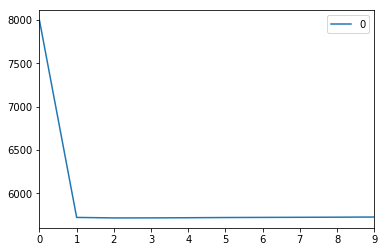

In [241]:
curve = pd.DataFrame(rmse_val) #elbow curve 
curve.plot()

In [242]:
rmse_val = [] #to store rmse values for different k
for K in np.arange(100,200,20):
    model = KNeighborsRegressor(n_neighbors = K)
    model.fit(X_train[["CUS_LAT","CUS_LONG"]], np.ravel(y_train))  #fit the model
    pred=model.predict(X_valid[["CUS_LAT","CUS_LONG"]]) #make prediction on valid set
    error = np.sqrt(metrics.mean_squared_error(y_valid,pred)) #calculate rmse
    rmse_val.append(error) #store rmse values
    print('RMSE value for k= ' , K , 'is:', error)

RMSE value for k=  100 is: 5723.3787888584875
RMSE value for k=  120 is: 5721.533502226133
RMSE value for k=  140 is: 5720.197618064238
RMSE value for k=  160 is: 5718.877870631169
RMSE value for k=  180 is: 5717.74316625253


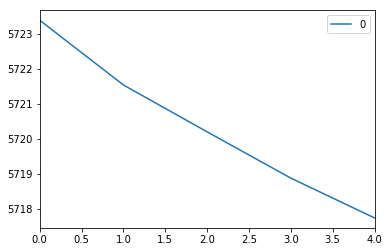

In [243]:
curve = pd.DataFrame(rmse_val) #elbow curve 
curve.plot()

### Train model with optimum K

In [244]:
from sklearn.neighbors import KNeighborsRegressor
# Create KNN classifier
model = KNeighborsRegressor(n_neighbors=201)
bst = model.fit(X_train[["CUS_LAT","CUS_LONG"]], np.ravel(y_train))
pred_train=model.predict(X_train[["CUS_LAT","CUS_LONG"]])
pred_valid=model.predict(X_valid[["CUS_LAT","CUS_LONG"]])
pred_test=model.predict(X_test[["CUS_LAT","CUS_LONG"]])

In [245]:
print("rmse train:",np.sqrt(metrics.mean_squared_error(y_train,pred_train)))
print("rmse valid:",np.sqrt(metrics.mean_squared_error(y_valid,pred_valid)))
print("rmse test:",np.sqrt(metrics.mean_squared_error(y_test,pred_test)))
print("rmse test random:",np.sqrt(metrics.mean_squared_error(y_test,pd.Series([-20000]*X_test.shape[0]))))

rmse train: 5766.309797222712
rmse valid: 5717.468642400547
rmse test: 5607.053299787021
rmse test random: 37723.44034301708


In [246]:
df_test["PRED_INCOME_NON_DEF"] = pred_test
df_train["PRED_INCOME_NON_DEF"] = pred_train
df_valid["PRED_INCOME_NON_DEF"] = pred_valid

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


### Comparison of RMSE with Default/Non Default 

In [247]:
print("RMSE DEFAULT:",np.sqrt(metrics.mean_squared_error(df_test.loc[df_test["RISK_FSTQPD30"]==1,"PRED_INCOME"],df_test.loc[df_test["RISK_FSTQPD30"]==1,"CLIENT_INR_INCOME"])))
print("RMSE NON DEFAULT:",np.sqrt(metrics.mean_squared_error(df_test.loc[df_test["RISK_FSTQPD30"]==0,"PRED_INCOME"],df_test.loc[df_test["RISK_FSTQPD30"]==0,"CLIENT_INR_INCOME"])))

RMSE DEFAULT: 5713.227162177654
RMSE NON DEFAULT: 5593.961268981419


In [248]:
print("RMSE DEFAULT:",np.sqrt(metrics.mean_squared_error(df_test.loc[df_test["RISK_FSTQPD30"]==1,"PRED_INCOME_NON_DEF"],df_test.loc[df_test["RISK_FSTQPD30"]==1,"CLIENT_INR_INCOME"])))
print("RMSE NON DEFAULT:",np.sqrt(metrics.mean_squared_error(df_test.loc[df_test["RISK_FSTQPD30"]==0,"PRED_INCOME_NON_DEF"],df_test.loc[df_test["RISK_FSTQPD30"]==0,"CLIENT_INR_INCOME"])))

RMSE DEFAULT: 5713.7548697303
RMSE NON DEFAULT: 5594.979226514761


### Client income of Default/Non Default 

In [249]:
df_test[["CLIENT_INR_INCOME","RISK_FSTQPD30"]].groupby("RISK_FSTQPD30").mean()

,CLIENT_INR_INCOME
RISK_FSTQPD30,
0,17214.633380
1,17599.013977


In [250]:
df_test[["PRED_INCOME","RISK_FSTQPD30"]].groupby("RISK_FSTQPD30").mean()

,PRED_INCOME
RISK_FSTQPD30,
0,16843.170169
1,17027.221782


In [251]:
df_test[["PRED_INCOME_NON_DEF","RISK_FSTQPD30"]].groupby("RISK_FSTQPD30").mean()

,PRED_INCOME_NON_DEF
RISK_FSTQPD30,
0,16857.828201
1,17045.784511


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001A86D428240>]],
      dtype=object)

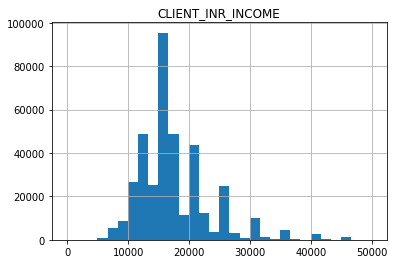

In [252]:
df_test[["CLIENT_INR_INCOME"]].hist(bins=30)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001A860920198>]],
      dtype=object)

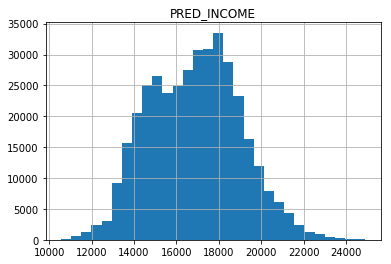

In [253]:
df_test[["PRED_INCOME"]].hist(bins=30)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001A86BD0F4A8>]],
      dtype=object)

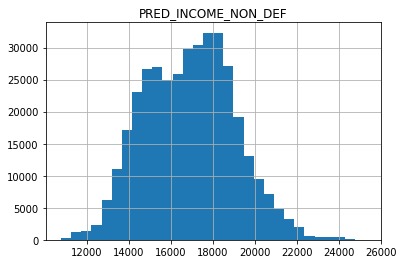

In [254]:
df_test[["PRED_INCOME_NON_DEF"]].hist(bins=30)

# Grid Conversions

In [153]:
grid_income = df_train[["GRID_ID","PRED_INCOME"]].groupby(by = "GRID_ID").mean().reset_index()

In [154]:
grid_income.columns = ["GRID_ID","PRED_INCOME_G"]

In [156]:
df_test= df_test.merge(grid_income, on= "GRID_ID")

In [158]:
print("rmse train:",np.sqrt(metrics.mean_squared_error(y_train,pred_train)))
print("rmse valid:",np.sqrt(metrics.mean_squared_error(y_valid,pred_valid)))
print("rmse test:",np.sqrt(metrics.mean_squared_error(y_test,pred_test)))
print("rmse test with grid:",np.sqrt(metrics.mean_squared_error(df_test.CLIENT_INR_INCOME,df_test.PRED_INCOME_G)))
print("rmse test random:",np.sqrt(metrics.mean_squared_error(y_test,pd.Series([-20000]*X_test.shape[0]))))

rmse train: 5741.299134432563
rmse valid: 5716.554338275181
rmse test: 5605.38983452086
rmse test with grid: 5597.3340261154
rmse test random: 37723.44034301708


# Check on Pallavi's Data

In [107]:
os.chdir(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Common Maps KNN\Data Files")

In [108]:
df1= pd.read_csv("income_pred_csv_to_latlng.csv",encoding='latin' )
df2= pd.read_csv("income_validation_1.csv",encoding='latin')

In [109]:
df1.head()

,SKP_CREDIT_CASE,LAT,LONG,GRID_ID
0,295138607,28.675737,77.331007,500_01866_04675
1,293048432,28.660962,77.318802,500_01864_04672
2,291974795,21.167083,72.874148,500_00927_03075
3,293786585,26.199213,78.136438,500_02014_04134
4,294747993,26.842516,80.865453,500_02548_04272


In [110]:
df2 = df2.merge(df1, on = 'SKP_CREDIT_CASE')

In [124]:
df2.dropna(subset=["LAT","LONG","GRID_ID"],inplace = True)

In [125]:
df2.columns

Index(['ID_CONTRACT', 'INCOME_DIFFERENCE', 'CODE', 'VALID', 'REASON',
       'INC_TYPE', 'DECLARED_INCOME', 'VERIFIED_INCOME', 'INC_DIF', 'COMMENTS',
       'SKP_CREDIT_CASE', 'SKP_CLIENT', 'TEXT_STREET_NUMBER', 'NAME_STREET',
       'NAME_LOCALITY', 'NAME_TOWN', 'NAME_REGION', 'NAME_DISTRICT',
       'CODE_ZIP_CODE', 'CLIENT_INR_INCOME', 'LAT', 'LONG', 'GRID_ID'],
      dtype='object')

In [126]:
df_valid = df2[['SKP_CREDIT_CASE','LAT', 'LONG', 'GRID_ID', 'CODE', 'VALID', 'REASON',
       'INC_TYPE', 'DECLARED_INCOME', 'VERIFIED_INCOME',  'COMMENTS', 'CLIENT_INR_INCOME']]

In [127]:
df_valid["DECLARED_INCOME"] = [x.upper().replace("DECLARED_INCOME-","").replace("NA","").replace(" ","") for x in df_valid["DECLARED_INCOME"]]
df_valid["VERIFIED_INCOME"] = [x.upper().replace("VERIFIED_INCOME-","").replace("NA","").replace(" ","") for x in df_valid["VERIFIED_INCOME"]]

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [128]:
import re

BAD_CHARS = ['&', '(', ')', ';', '-', '_', '>', '<', '=']
pat = '|'.join(['({})'.format(re.escape(c)) for c in BAD_CHARS])

df_valid = df_valid[~df_valid['VERIFIED_INCOME'].str.contains(pat)]

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  


In [129]:
df_valid.shape

(12939, 12)

In [134]:
df_valid.VERIFIED_INCOME= pd.to_numeric(df_valid.VERIFIED_INCOME)
df_valid.DECLARED_INCOME= pd.to_numeric(df_valid.DECLARED_INCOME)

In [135]:
df_valid["PRED_INCOME"] = model.predict(df_valid[["LAT","LONG"]])

In [137]:
df_valid.to_csv("income_pred_output.csv")